#### **Authors:**
Izquierdo Alvarez, Mario.

Romero Romero, Martín.

# Comparison of final results

#### Imports

In [3]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

In [4]:
sys.path.append('02_wgan/')
sys.path.append('03_VAE/')

In [5]:
from utils import display

#### Utility functions

In [6]:
def csv_to_dict(path):
    # Read the CSV file
    data = pd.read_csv(path)
    
    # Ensure 'model_name' and 'FID' columns exist
    if 'model_name' not in data.columns or 'FID' not in data.columns:
        raise ValueError("The CSV must contain 'model_name' and 'FID' columns")
    
    # Convert to dictionary
    models_dict = pd.Series(data.FID.values, index=data.model_name).to_dict()
    
    return models_dict

In [7]:
def plot_results_grouped(results_dicts, title='Title', figsize=(20, 10), font_size=12, y_lim = None):
    ''' 
    This function allows plotting several configurations of different methods on the same bar plot.
    A dictionary with each method as the key and with configurations and results dict as the value will be used as input.
    Example: {'Method_1': {'config_1':(1, 0.5), ...}, 'Method_2':{...}...}. Each Method will be plotted with a different color.
    '''
    
    methods = list(results_dicts.keys())
    colors = ['seagreen', 'tan', 'lightsteelblue', 'mediumpurple', 'dimgrey', 'mediumaquamarine']  # Colors for each method
    color_map = dict(zip(methods, colors[:len(methods)]))
    
    fig, ax = plt.subplots(figsize=figsize)
    width = 0.35  # Bar width
    
    total_configs = sum([len(results_dicts[method]) for method in methods])  # Total configurations
    x = np.linspace(0, total_configs * width * 1.5, total_configs)  # Spacing
    
    min_value = float('inf')  # Initialize min value for accuracy
    
    current_position = 0
    for method in methods:
        labels = list(results_dicts[method].keys())
        results = list(results_dicts[method].values())
        
        # Update min_value if current results contain a new min
        min_value = min(min_value, min(results))
        
        # Creating the bars for each method
        rects = ax.bar(x[current_position:current_position+len(labels)], results, width,
                       label=method, color=color_map[method], alpha=0.6)
        ax.bar_label(rects, padding=3, fontsize=font_size)
        
        current_position += len(labels)  # Update the position for the next group of bars
    
    ax.set_ylabel('FID', fontsize=font_size)
    ax.set_title(title, fontsize=font_size + 2)
    
    all_labels = [config for method in methods for config in results_dicts[method]]
    ax.set_xticks(x[:len(all_labels)])
    ax.set_xticklabels(all_labels, rotation=45, ha="right", fontsize=font_size)
    
    ax.legend(title="Methods", title_fontsize=font_size, fontsize=font_size)
    
    ax.tick_params(axis='y', labelsize=font_size)
    if y_lim:
        plt.ylim(*y_lim)

    # Draw a horizontal line at the minimum value
    plt.axhline(y=min_value, color='brown', alpha=0.6, linestyle='--', label=f'Min FID: {min_value}')
    plt.legend(title="Methods", title_fontsize=font_size, fontsize=font_size)
    
    fig.tight_layout()
    plt.show()

In [8]:
def interpolate_and_generate_images(generator, n_points):
    """
    Generate images by interpolating between two random points in the latent space.

    Parameters:
    n_points (int): Number of interpolation points.

    Returns:
    None
    """
    # Generate two random points in the latent space
    z1 = np.random.normal(size=(1, Z_DIM))
    z2 = np.random.normal(size=(1, Z_DIM))

    # Generate n_points interpolation vectors
    interpolation_vectors = np.linspace(0, 1, n_points).reshape(-1, 1)
    interpolated_z = z1 * (1 - interpolation_vectors) + z2 * interpolation_vectors

    # Generate images from the interpolated vectors
    interpolated_z = interpolated_z.reshape(n_points, Z_DIM)
    generated_images = generator.predict(interpolated_z)

    # Normalize images to [0, 1] range
    generated_images = (generated_images + 1) / 2.0

    # Plot all images in a single row
    plt.figure(figsize=(20, 2))
    for i in range(n_points):
        plt.subplot(1, n_points, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
def VAE_linear_interpolation(images, n_to_show = 8):
    limit_images = images[0:2]
    
    fig = plt.figure(figsize=(12, 3))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.4)
    
    left = limit_images[0]
    img=left.squeeze()
    sub = fig.add_subplot(2, n_to_show, 1)
    sub.axis('off')
    sub.imshow(img)
              
    right = limit_images[1]
    img=right.squeeze()
    sub = fig.add_subplot(2, n_to_show, n_to_show)
    sub.axis('off')
    sub.imshow(img)
    
    limit_encodings = vae_encoder.predict(limit_images)
    #print(limit_encodings.shape)
    interp_encodings = np.zeros((n_to_show, limit_encodings.shape[1]))
    interp_encodings[0] = limit_encodings[0]
    interp_encodings[-1] = limit_encodings[-1]
    step_size = 1 / (interp_encodings.shape[0] - 1)
    
    for i in range(1, interp_encodings.shape[0] - 1):
        interpolation_factor = i * step_size
        #interp_encodings[i] = (1 - interpolation_factor) * limit_encodings[
        interp_encodings[i] = (1 - interpolation_factor) * limit_encodings[0] + interpolation_factor * limit_encodings[1]  # Línea completada
    #print(interp_encodings.shape)
    interp_images = vae_decoder.predict(interp_encodings)
                                           
    for i in range(n_to_show):
        img = interp_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, n_to_show+i+1)
        sub.axis('off')
        sub.imshow(img)
    plt.show()


## **WGAN-gp vs VA FID**

In [10]:
fid_gan_path = os.path.join('.','02_wgan', 'FID_GAN.csv')
fid_va_path = os.path.join('.','03_VAE', 'FID_VAE.csv')

In [15]:
fid_gan = csv_to_dict(fid_gan_path)
fid_vae = csv_to_dict(fid_va_path)

In [16]:
results = {'GANs' : fid_gan,'VAs' : fid_vae}

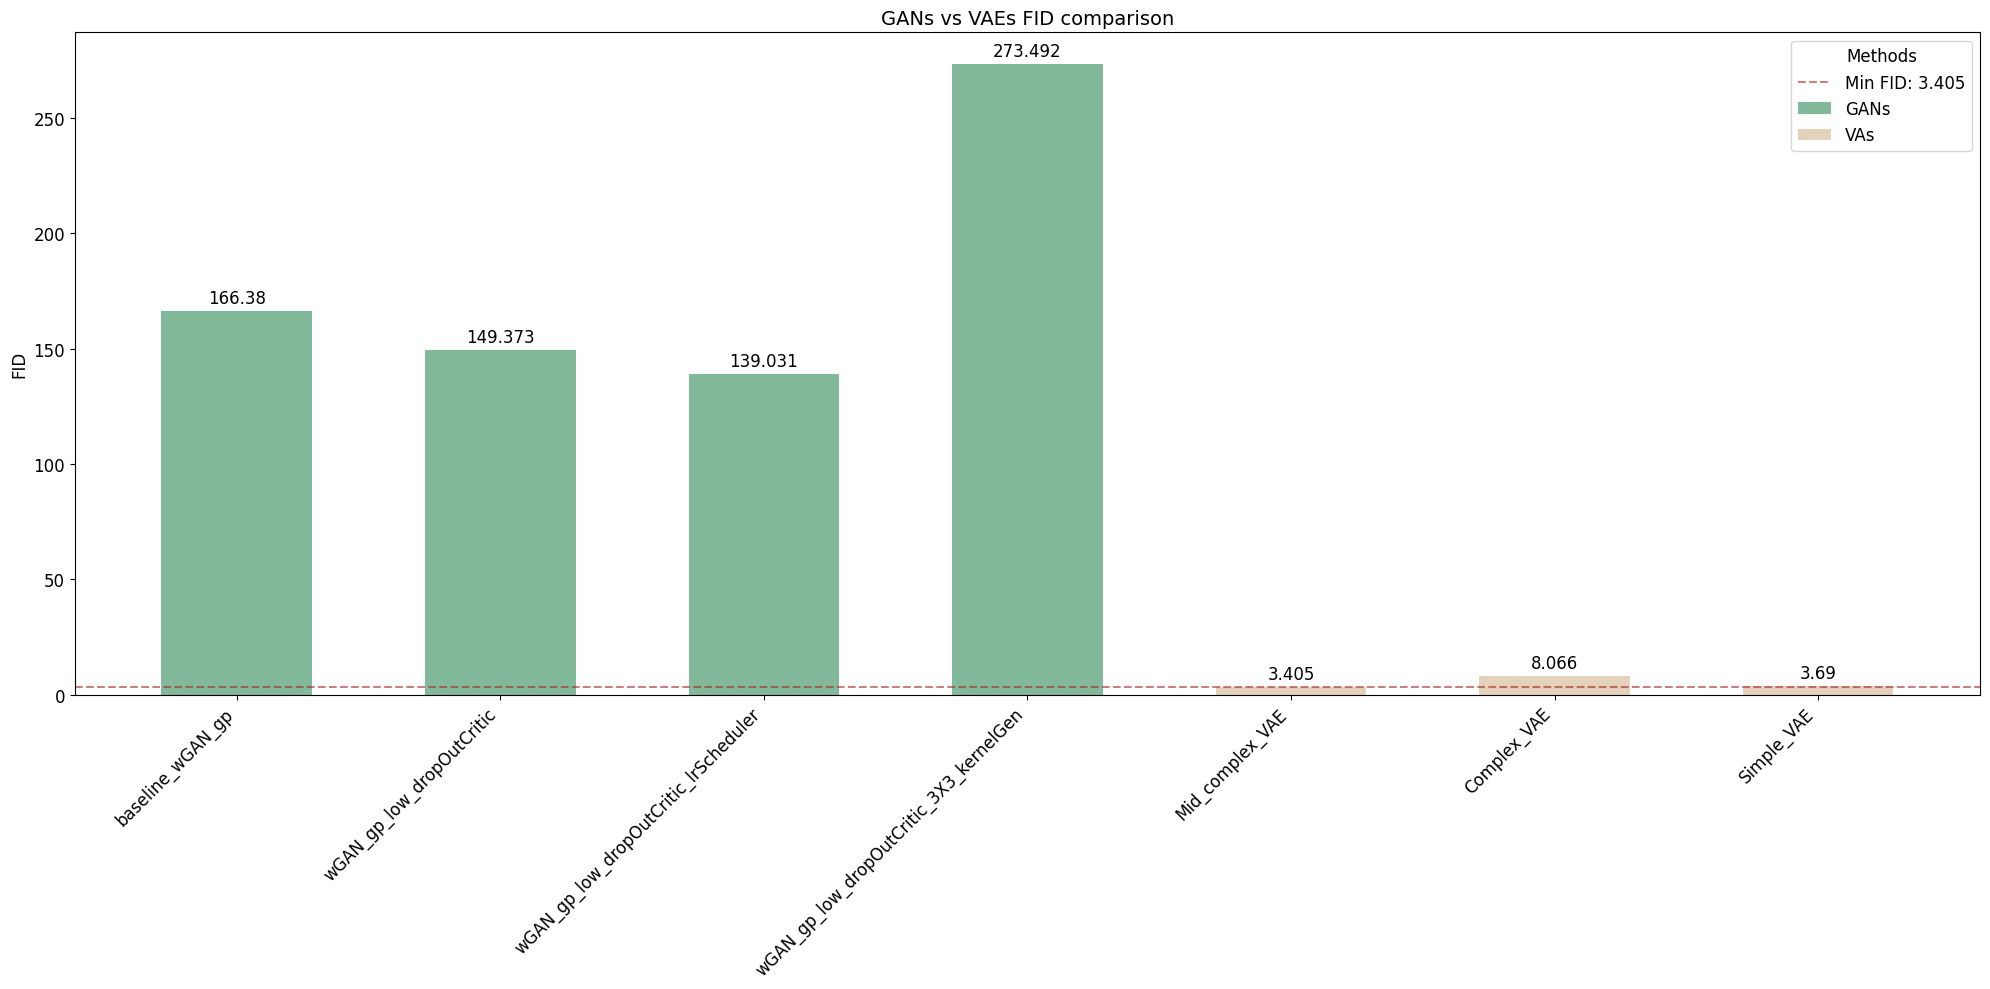

In [17]:
plot_results_grouped(results, title='GANs vs VAEs FID comparison')

<div style="background-color: #ffffcc; padding: 10px;">

### **Results discussion**

As observed, the WGAN-GP with the best results in terms of FID is the one that used reduced Dropout in the Critic and a Learning Rate Scheduler to refine the optimization in the final stages of training, achieving the best FID among the WGAN-GPs: **139.031**. By using a Critic with less Dropout, we managed to enhance the stability of the training process and improve the quality of the generated images. Additionally, the use of a Learning Rate Scheduler allowed for more precise adjustments of the learning rate during training, leading to finer optimization and reducing the likelihood of the model overshooting the minima (For more information, give a look to the specific notebook `02_wgan/Assignment_wgan_gp.ipynb`).

In a qualitative evaluation of the images, the improvements were noticeable, with the images appearing more coherent and possessing fewer severe artifacts compared to previous models. However, several problems persist. The generated images still struggle with realism, and despite some being better or acceptable, many images remain far from convincing as real faces. Artifacts and inconsistencies are still present, indicating that the model's ability to generate highly detailed and realistic images is limited. Future work should focus on integrating advanced techniques such as ProGAN, StyleGAN, and BigGAN to address these issues and further improve the quality of the generated images.

On the other hand, the Variational Autoencoders (VAEs) have also been tested and achieved significantly lower FID values compared to the GANs, with the best FID being **3.405**. Qualitatively, the images generated by the VAEs show fewer artifacts and appear more realistic. However, the generated images tend to be blurrier. This blurriness is due to the inherent probabilistic nature of VAEs, often resulting in smoother images that lack the sharp details captured by GANs.

The benefits of GANs over VAEs in generating new images include the ability to produce sharper and more detailed images, thanks to their adversarial training process, which encourages the generation of images without the characteristic blurriness from the VAEs. GANs are also better at capturing complex data distributions and generating **diverse** images.

The significantly better FID achieved by VAEs can be attributed to their probabilistic approach to modeling the data distribution, which allows them to capture the overall structure of the data more effectively. VAEs explicitly maximize the data likelihood, resulting in a model that better approximates the **true data distribution**, leading to a lower FID score. However, this comes at the **cost of image sharpness**, highlighting the trade-off between realism and detail in generative models.

In summary, while **VAEs** excel in producing realistic images with **fewer artifacts** and achieving **lower FID scores**, **GANs** offer advantages in generating **sharper** and more detailed images.
</div>

## **GAN Latent Space and Interpolation**

In [13]:
Z_DIM = 128

In [17]:
# Load the trained generator model
generator = load_model("./02_wgan/models/generator_lrS.keras")

### Generate some images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


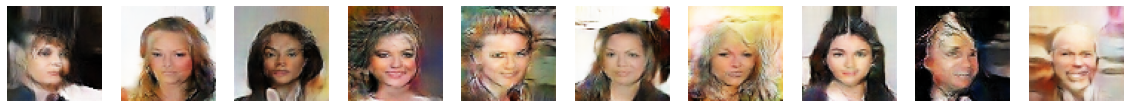

In [31]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = generator.predict(z_sample)
display(imgs, cmap=None)

### Explore image interpolation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


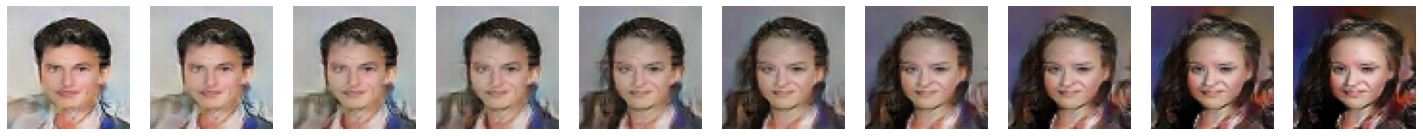

In [101]:
interpolate_and_generate_images(generator, 10)

## **VAE Latent Space and Interpolation**

In [11]:
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
INPUT_DIM = (64,64,3)
BATCH_SIZE = 512
Z_DIM = 200
data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory('./archive/img_align_celeba/', 
    target_size = (INPUT_DIM[0], INPUT_DIM[1]),
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = 'input',
    subset = 'training',
    color_mode='rgb'
    )

vae_encoder=load_model('./03_VAE/vae_encoder.keras',safe_mode=False)
vae_decoder=load_model('./03_VAE/vae_decoder.keras',safe_mode=False)

Found 202599 images belonging to 1 classes.


1/1 [==============================] - 0s 12ms/step


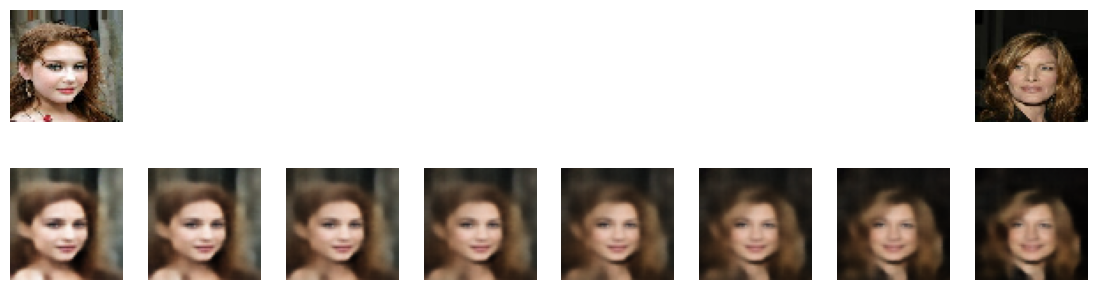

In [16]:
import random
example_batch = next(data_flow)
example_batch = example_batch[0]
random_number1 = random.randint(0, len(example_batch))
random_number2 = random.randint(0, len(example_batch))
example_images = np.array([example_batch[random_number1], example_batch[random_number2]])

VAE_linear_interpolation(example_images)

<div style="background-color: #e6ffe6; padding: 10px;">

## **Summary of Experimental Insights**
In our experiments, we explored various WGAN-GP models and Variational Autoencoders (VAEs) to generate face images. The WGAN-GP model with reduced Dropout in the Critic and a Learning Rate Scheduler achieved the best results, demonstrating improved stability and quality with a FID of **139.031**. The qualitative analysis showed more quality images and fewer artifacts, though realism remained an issue. In contrast, VAEs achieved a significantly lower FID of **3.405**, producing images with **fewer artifacts** but more **blurriness** due to their probabilistic nature. While GANs generate **sharper** images, VAEs excel in overall realism.

### **Important Insights**
- WGAN-GP with reduced Dropout and Learning Rate Scheduler achieved best FID of **139.031**.
- **Reduced Dropout** in Critic improved **stability** and image **quality**.
- **Learning Rate Scheduler** allowed finer optimization in final training stages.
- Realism in GANs is still an **issue**.
- VAEs achieved a significantly lower FID of **3.405**.
- VAE-generated images had **fewer artifacts** and appeared more realistic, but were **blurrier**.
- GANs stands out for generating **sharper**, more detailed images.
- VAEs' lower FID may be due to better data distribution approximation.
- A **simple** architecture makes VAE find quite **good results** in a few training periods.
</div>